# Full Sim Training

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm_notebook as tqdm
from tqdm import trange, tnrange

from deep_qnet_agent import DQNAgentDemo
from environment import Environment, LanderEnvironment
from full_lander_sim import *
from gym import wrappers

In [4]:
def save_agent(agent, env, fname):
    env.reset()
    
    agentcon = agent_config()
    netcon = network_config()
    for key in agentcon.keys():
        agentcon[key] = getattr(agent, key)
    for key in netcon.keys():
        netcon[key] = getattr(agent, key)
        
    netparams = {}
    netparams['w_in'] = agent.sess.run(agent.w_in)
    netparams['b_in'] = agent.sess.run(agent.b_in)
    netparams['W'] = agent.sess.run(agent.W)
    agent_data = {'agentcon':agentcon, 'netcon':netcon, 'netparams':netparams,
                 'SA':(agent.state_size, agent.action_size), 'env':env}
    pickle.dump(agent_data,open(fname,'wb'))
    
def save_deep_agent(agent, env, fname):
    env.reset()
    
    agentcon = agent_config()
    netcon = network_config()
    for key in agentcon.keys():
        agentcon[key] = getattr(agent, key)
    for key in netcon.keys():
        netcon[key] = getattr(agent, key)
        
    netparams = {}
    for w in agent.weights.keys():
        netparams[w] = agent.sess.run(agent.weights[w])
    for b in agent.biases.keys():
        netparams[b] = agent.sess.run(agent.biases[b])

    agent_data = {'agentcon':agentcon, 'netcon':netcon, 'netparams':netparams,
                 'SA':(agent.state_size, agent.action_size), 'env':env}
    pickle.dump(agent_data,open(fname,'wb'))
    
def load_agent(fname):
    agent_data = pickle.load(open(fname,'rb'))
    env = agent_data['env']
    agent = QNetAgent(agent_data['agentcon'],agent_data['netcon'],env)

    netparams = agent_data['netparams']
    with agent.sess.as_default():
        agent.w_in.load(netparams['w_in'])
        agent.b_in.load(netparams['b_in'])
        agent.W.load(netparams['W'])
    print(agent.sess.run(agent.W))
    
    return agent, env

def load_deep_agent(fname):
    agent_data = pickle.load(open(fname,'rb'))
    env = agent_data['env']
    agent = DQNAgentDemo(agent_data['agentcon'],agent_data['netcon'],env)

    netparams = agent_data['netparams']
    with agent.sess.as_default():
        agent.w_in.load(netparams['w_in'])
        agent.b_in.load(netparams['b_in'])
        agent.W.load(netparams['W'])
    print(agent.sess.run(agent.W))
    
    return agent, env

def reset_agent(agent, netcon, agentcon):
    """
    This function resets an agent's hyperparameters while maintaining its weights
    """
    # Reset hyperparams
    for key in agentcon.keys():
        setattr(agent, key, agentcon[key])
    for key in netcon.keys():
        setattr(agent, key, netcon[key])
    agent.eps = agent.eps0
    
    # Assign target network
    agent.sess.run(agent.wt_assign)
    agent.sess.run(agent.bt_assign)
    agent.sess.run(agent.Wt_assign)
    
    # Memory (maintains state transition memory)
    agent.prev_s=[]
    agent.prev_a=[]
    agent.step_count=0
    agent.ep_no=0
    
    return agent

def do_run(agent, env, N_ep):
    R_ep = []
    t = tnrange(N_ep, desc='bar_desc', leave=True)
#     for ep_no in tqdm(range(N_ep)):
    for ep_no in t:
        observation = env.reset()
        done = False
        r = 0
        n_step = 0
        while not done:
            action = agent.action_select(env,observation)
            observation, reward, done, info = env.step(action)
            agent.update_net(observation,reward,done)
            r += reward
            n_step +=1
        R_ep.append(r)
        t.set_description('Last reward: {}'.format(r))
        t.refresh()
    return R_ep, agent, env

def agent_demo(agent, env, N_ep):
    R_ep = []
    for ep_no in tqdm(range(N_ep)):
        observation = env.reset()
        done = False
        r = 0
        while not done:
            action = agent.action_select(env,observation)
            observation, reward, done, _ = env.step(action)
            env.render()
            r += reward
        R_ep.append(r)
    return R_ep

def data_smooth(data,n_avg):
	# A function to average data over n_avg timesteps
	ind_vec = np.arange(n_avg,len(data)+1,n_avg)
	data_avg = [0]
	for ind in ind_vec:
		data_avg.append(np.mean(data[ind-n_avg:ind]))
	return data_avg

## Environment

In [ ]:
demo_heuristic_lander(MarsLander())

In [6]:
exp_heuristic = exp_heuristic_lander(MarsLander())
fname = 'lander_full_heuristic_13_11'
np.save(open(fname,'wb'),exp_heuristic)

Episode 1
observations: +0.00 -0.00 +0.00 +0.00 -0.00 +0.00 +1.00 +1.00
step 1872 total_reward -48.42
Episode 1
observations: +0.00 -0.00 +0.00 +0.00 -0.00 +0.00 +1.00 +1.00
step 1876 total_reward -41.31
Episode 1
observations: -0.00 -0.00 +0.00 +0.00 +0.00 +0.00 +1.00 +1.00
step 1872 total_reward -46.27
Episode 1
observations: -0.00 -0.00 +0.00 +0.00 +0.00 +0.00 +1.00 +1.00
step 1879 total_reward -45.66
Episode 1
observations: +0.01 -0.00 +0.00 +0.00 -0.00 +0.00 +1.00 +1.00
step 1873 total_reward -48.65


In [7]:
np.shape(exp_heuristic)

(9377, 5)

## Training

In [5]:
def network_config():
    netcon = {}
    netcon['alpha'] = 0.001
    netcon['clip_norm'] = None
    netcon['update_steps'] = 50
    netcon['N_hid_1'] = 120
    netcon['N_hid_2'] = 80
    netcon['activation'] = 'tanh'
    netcon['init_mag'] = 0.01
    return netcon

def agent_config():
    agentcon = {}
    agentcon['gamma'] = 0.9
    agentcon['eps0'] = 0.5
    agentcon['epsf'] = 0.0
    agentcon['n_eps'] = 500
    agentcon['minib'] = 20
    agentcon['minib_demo'] = 50
    agentcon['max_mem'] = 500000
    return agentcon

In [ ]:
fname = 'lander_full_heuristic_13_11'
demo_exp = np.load(open(fname,'rb'),allow_pickle=True).tolist()

print(agent_config())
print(network_config())

mean_end = -500
agent_no = 0
while mean_end<100:
    agent_no+=1
    print('Agent ' + str(agent_no))
    
    N_ep = 600
    env = LanderEnvironment()
    agent = QNetAgentDemo(agent_config(),network_config(),env,demo_exp)
    
    R_ep, agent, env = do_run(agent, env, N_ep)
    mean_end = np.mean(R_ep[-100:])
    print('R end: ' + repr(mean_end))
    
    save_agent(agent, env, 'agent'+str(agent_no))
    pickle.dump(R_ep, open('reward'+str(agent_no),'wb'))

## Deep Agents

In [52]:
fname = 'lander_full_heuristic_13_11'
demo_exp = np.load(open(fname,'rb'),allow_pickle=True).tolist()

env = LanderEnvironment()
agent = DQNAgentDemo(agent_config(),network_config(),env,demo_exp)

In [57]:
s1 = env.reset()
s, r, d, _ = env.step(1)

In [58]:
agent.action_select(env,s1)

0

In [54]:
asdf = agent.sess.run(agent.target_weights['w1'])
print(asdf[0])

[ 2.1796165e+00 -9.9561536e-01  9.3502635e-01 -9.1046154e-01
 -5.7210855e-04  2.3380396e-01  2.3570715e-01  1.6443604e-01
  4.7123483e-01 -1.1434834e+00 -4.3427014e-01 -1.2813230e+00
  1.2802505e+00  1.2963850e+00 -5.6095493e-01  8.9594066e-01
  1.2157131e+00  3.0109772e-01  1.1272312e+00  6.5195638e-01
 -4.5691055e-01  1.3144650e+00 -9.6425718e-01  6.3277297e-02
  6.0508782e-01 -1.1533339e+00 -1.2854043e+00  9.9293870e-01
 -1.0904906e+00 -3.7116900e-02 -1.9525652e-01 -4.3382615e-02
  1.9113785e-01 -8.2117550e-02 -1.0431737e+00 -1.9047740e+00
 -1.2578098e+00  2.6165736e-01 -4.8489343e-02  2.5848067e-01
  1.5080854e+00 -2.0559682e-01 -8.5770673e-01 -3.2241946e-01
 -1.1612589e+00  5.9074372e-01  2.5714280e-03 -1.2965275e+00
  5.1712358e-01  9.6086788e-01  8.5648704e-01  7.0624065e-01
  1.2490435e+00  1.1990420e+00 -9.9259639e-01 -1.3364767e-01
  1.1368495e+00 -1.4905995e+00  1.1073046e+00  1.6948447e+00
 -4.7104046e-02  7.5509031e-03 -3.8765371e-01  8.3640569e-01
  1.7749270e+00 -1.11865

In [55]:
asdf = agent.sess.run(agent.weights['w1'])
print(asdf[0])

[ 2.1796165e+00 -9.9561536e-01  9.3502635e-01 -9.1046154e-01
 -5.7210855e-04  2.3380396e-01  2.3570715e-01  1.6443604e-01
  4.7123483e-01 -1.1434834e+00 -4.3427014e-01 -1.2813230e+00
  1.2802505e+00  1.2963850e+00 -5.6095493e-01  8.9594066e-01
  1.2157131e+00  3.0109772e-01  1.1272312e+00  6.5195638e-01
 -4.5691055e-01  1.3144650e+00 -9.6425718e-01  6.3277297e-02
  6.0508782e-01 -1.1533339e+00 -1.2854043e+00  9.9293870e-01
 -1.0904906e+00 -3.7116900e-02 -1.9525652e-01 -4.3382615e-02
  1.9113785e-01 -8.2117550e-02 -1.0431737e+00 -1.9047740e+00
 -1.2578098e+00  2.6165736e-01 -4.8489343e-02  2.5848067e-01
  1.5080854e+00 -2.0559682e-01 -8.5770673e-01 -3.2241946e-01
 -1.1612589e+00  5.9074372e-01  2.5714280e-03 -1.2965275e+00
  5.1712358e-01  9.6086788e-01  8.5648704e-01  7.0624065e-01
  1.2490435e+00  1.1990420e+00 -9.9259639e-01 -1.3364767e-01
  1.1368495e+00 -1.4905995e+00  1.1073046e+00  1.6948447e+00
 -4.7104046e-02  7.5509031e-03 -3.8765371e-01  8.3640569e-01
  1.7749270e+00 -1.11865

Run the deep agent

In [ ]:
fname = 'lander_full_heuristic_13_11'
demo_exp = np.load(open(fname,'rb'),allow_pickle=True).tolist()

print(agent_config())
print(network_config())

N_attempt = 20
for agent_no in range(N_attempt):
    print('Agent ' + str(agent_no))
    
    N_ep = 600
    env = LanderEnvironment()
    agent = DQNAgentDemo(agent_config(),network_config(),env,demo_exp)
    
    R_ep, agent, env = do_run(agent, env, N_ep)
    mean_end = np.mean(R_ep[-100:])
    print('R end: ' + repr(mean_end))
    
    save_deep_agent(agent, env, 'agent'+str(agent_no))
    pickle.dump(R_ep, open('reward'+str(agent_no),'wb'))

{'gamma': 0.9, 'eps0': 0.5, 'epsf': 0.0, 'n_eps': 500, 'minib': 20, 'minib_demo': 50, 'max_mem': 500000}
{'alpha': 0.001, 'clip_norm': None, 'update_steps': 50, 'N_hid_1': 120, 'N_hid_2': 80, 'activation': 'tanh', 'init_mag': 0.01}
Agent 0


In [9]:
R = agent_demo(agent,env,5)

In [10]:
env.gym_env.close()

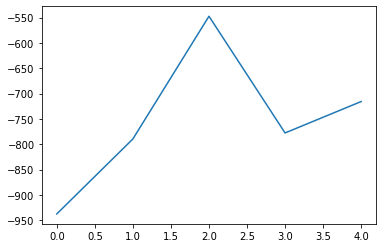

In [11]:
plt.plot(R)